In [ ]:
import os
import joblib

from dotenv import load_dotenv
from google import genai
import pandas as pd
import numpy as np
import spacy

load_dotenv()
path = "../data/processed/market_products_features.csv"
dtypes = {"sku": str, "gtin": str}
df = pd.read_csv(path, dtype=dtypes, index_col=0, sep="|")
df.sample()

,sku,gtin,specifications,brand,description,product_name,review_tags,category_name,root_category_name,main_image,...,other_attributes_parsed,size_l,size_w,size_h,size_units,weight,weight_unit,weight_kg,weight_kg_source,volume_source
643,1274809612,702298198680,"[{""name"":""Features"",""value"":""Quick Drying, Lig...",Inadays,7-Inch Inseam Mens Swimming Trunks Our swi...,Inadays Mens Swim Trunks with Compression Line...,"[""Fit (43)"",""Quality (21)"",""Comfort (20)"",""Pri...",Mens Swimwear,Clothing,"""https://i5.walmartimages.com/seo/Inadays-Mens...",...,"[{'name': 'Fabric Care Instructions', 'value':...",10.6,9.2,6.3,NaN,NaN,NaN,0.47,completed,completed


Las siguientes son posibles candidatos para embeddings
* specifications (limpiar)
* description
* product_name
* sizes (limpiar)

In [3]:
df["weight_kg"].describe()

count    878.000000
mean       1.680210
std        5.196577
min        0.005377
25%        0.470000
50%        0.470000
75%        0.796402
max       57.380400
Name: weight_kg, dtype: float64

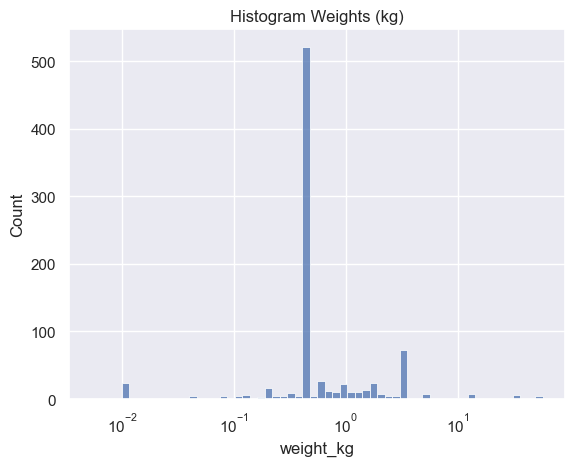

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.histplot(df["weight_kg"], log_scale=True)
plt.title("Histogram Weights (kg)")
plt.show()

La asimetria en la distribusion del peso puede ser un reto para los modelos, una libreria como [smogn](https://pypi.org/project/smogn/) puede dar como resultado mejores modelos.

# Embeddings

In [5]:
nlp = spacy.load("en_core_web_md")
nlp.disable_pipes("parser", "ner")
print(nlp.pipe_names)

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


In [ ]:
# Genera los vectores usando el modelo de spacy
df["product_name_vector"] = df["product_name"].apply(lambda x: nlp(x).vector)
df["product_name_vector"].head()

0    [-0.6645359, 0.25058463, -0.085736245, 0.30602...
1    [-0.5852896, 0.021247137, -0.16949064, -0.0435...
2    [-0.65554154, 0.14395839, -0.02887265, 0.15746...
3    [-0.67238826, -0.06380527, -0.15272984, 0.0498...
4    [-0.7162662, 0.047542773, -0.10108063, 0.02942...
Name: product_name_vector, dtype: object

# Training data

In [12]:
print(df["weight_kg_source"].value_counts())
has_weight = (df["weight_kg"].notna()) & (df["weight_kg_source"] == "extracted")
df[has_weight].sample(3)

weight_kg_source
completed    667
extracted    211
missing       22
Name: count, dtype: int64


,sku,gtin,specifications,brand,description,product_name,review_tags,category_name,root_category_name,main_image,...,size_l,size_w,size_h,size_units,weight,weight_unit,weight_kg,weight_kg_source,volume_source,product_name_vector
524,896599636,754168196449,"[{""name"":""Brand"",""value"":""VOUA""},{""name"":""Bed ...",VOUA,Peach-skin fabric surface - Extremely soft ...,Comforter Full Red All Season Down Alternative...,"[""Comfort (65)"",""Color (47)"",""Price (43)"",""Qua...",Down Alternative Comforters,Home,"""https://i5.walmartimages.com/seo/Comforter-Fu...",...,54.00,48.40,7.10,NaN,6.00,lb,2.721600,extracted,completed,"[-0.7045157, 0.21252277, -0.21872683, -0.05183..."
122,1796059258,41877181171,"[{""name"":""Country of Origin - Textiles"",""value...",wendunide,The preferential price and the quality of the ...,wendunide summer dress Women's Vintage 1920s S...,[],Womens Dresses,Clothing,"""https://i5.walmartimages.com/seo/wendunide-su...",...,11.76,7.92,0.84,in,11.19,oz,0.316677,extracted,extracted,"[-0.6975061, 0.036719713, -0.20524563, 0.21172..."
531,187071360,47947773802,"[{""name"":""Features"",""value"":""Elastic Waistband...",Soffe,SOFFE Mens AUTHENTIC SHORT (B037),Mens AUTHENTIC SHORT (B037),"[""Size (4)""]",Womens Shorts,Clothing,"""https://i5.walmartimages.com/seo/Mens-AUTHENT...",...,10.60,9.20,6.30,NaN,4.32,oz,0.122256,extracted,completed,"[-0.55859, 0.25011316, 0.08883851, -0.04877333..."


In [13]:
df_train = df[has_weight].copy()
df_predict = df[~has_weight].copy()
print(df_train.shape)
print(df_predict.shape)

(211, 27)
(689, 27)


# Models

In [94]:
def save_model(model, filename):
    """
    Save a trained model to disk using joblib.

    Parameters:
        model: Trained model object (e.g., sklearn estimator)
        filename: Path to save the model file (e.g., 'model.pkl')
    """
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

## SVR

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import numpy as np

X = np.stack(df_train["product_name_vector"].values)
y = df_train["weight_kg"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
# busqueda aleatoria de hiperparametros
param_dist = {
    "C": [0.1, 1, 10, 100, 1000],
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
    "epsilon": [0.01, 0.1, 0.2, 0.5, 1],
    "kernel": ["rbf", "linear"],
}
random_search = RandomizedSearchCV(
    SVR(),
    param_distributions=param_dist,
    n_iter=80,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", -random_search.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'kernel': 'rbf', 'gamma': 1, 'epsilon': 0.01, 'C': 1000}
Best CV score: 42.65496261680302


In [ ]:
def show_model_metrics(y_test, y_pred):
    # Calculate metrics for SVR model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("SVR Model Performance Report:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Median Absolute Error: {medae:.4f}")
    print(f"R^2 Score: {r2:.4f}")


# Predict and evaluate
y_pred = random_search.predict(X_test)
show_model_metrics(y_test, y_pred)

SVR Model Performance Report:
Mean Squared Error (MSE): 20.2253
Mean Absolute Error (MAE): 2.8318
Median Absolute Error: 2.1865
R^2 Score: 0.7842


In [74]:
# Create a DataFrame to compare y_test, y_pred, and category
comparison_df = pd.DataFrame(
    {
        "y_test": y_test.values,
        "y_pred_svr": y_pred,
        "category_name": df_train.loc[y_test.index, "category_name"].values,
        "product_name": df_train.loc[y_test.index, "product_name"].values,
    }
)
comparison_df.sample(5)

,y_test,y_pred_svr,category_name,product_name
24,9.97920,4.865943,All Area Rugs,Emma + Oliver 6'x9' Contemporary Swirl Plush P...
25,1.81440,5.176052,Comforter Sets,HIG Light Weight Down Alternative Comforter Se...
17,57.38040,53.940723,7 Piece Patio Dining Set,WestinTrends Malibu 7 Piece Adirondack Outdoor...
10,3.44736,1.543671,Colored Sheets,Bare Home Cozy Fleece Sheet Set - Extra Plush ...
4,0.11340,6.194388,Native Deodorant,"(2 pack) Native Deodorant, Coconut & Vanilla, ..."


In [100]:
save=False
if save==True:
    save_model(random_search, "../models/trained_models/weight_model_svr.pkl")

## KNN

In [92]:
# Define parameter grid for KNN
param_dist_knn = {
    "n_neighbors": [3, 5, 7, 9, 13, 15, 19, 25],
    "weights": ["uniform", "distance"],
    "p": [1, 2],  # 1: Manhattan, 2: Euclidean
}

# Randomized search for KNN
random_search_knn = RandomizedSearchCV(
    KNeighborsRegressor(),
    param_distributions=param_dist_knn,
    n_iter=30,
    scoring="neg_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
)
random_search_knn.fit(X_train, y_train)

print("Best KNN parameters:", random_search_knn.best_params_)
print("Best KNN CV score:", -random_search_knn.best_score_)

Best KNN parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 5}
Best KNN CV score: 52.90118498852122


In [85]:
# Predict and evaluate
y_pred_knn = random_search_knn.predict(X_test)
show_model_metrics(y_test, y_pred_knn)

SVR Model Performance Report:
Mean Squared Error (MSE): 38.8833
Mean Absolute Error (MAE): 3.7111
Median Absolute Error: 1.7446
R^2 Score: 0.5852


In [ ]:
save=False
if save==True:
    save_model(random_search_knn, "../models/trained_models/weight_model_knn.pkl")

Model saved to ../models/trained_models/weight_model_knn.pkl


# test api

In [ ]:
api_key = os.getenv("api_key")
client = genai.Client(api_key=api_key)

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents="""What is the average weight of a piece of clothing.""",
)
print(response.text)

That's a great question, but there isn't a single, universally "average" weight for a piece of clothing because the weight varies enormously based on several factors:

1.  **Type of Garment:** A sock is vastly different from a winter coat.
2.  **Material:** Cotton, wool, denim, silk, polyester, linen all have different densities and weights.
3.  **Size:** A small T-shirt weighs less than an XL T-shirt.
4.  **Thickness/Construction:** A light summer dress vs. a heavy, lined winter dress.

However, I can give you some typical ranges for common items:

*   **Very Light (20-100 grams / 0.7-3.5 oz):**
    *   Underwear, socks, silk scarf, thin camisole.
*   **Light (100-300 grams / 3.5-10.5 oz):**
    *   T-shirt, tank top, light blouse, thin pajamas.
*   **Medium (300-800 grams / 10.5 oz - 1.7 lbs):**
    *   Jeans, dress shirt, light sweater, summer dress, tracksuit bottoms, light jacket.
*   **Heavy (800 grams - 2 kg / 1.7 - 4.4 lbs):**
    *   Denim jacket, thick sweater, winter jeans, 